# Far-field Irradiance and Numerical Aperture

**Matthew Spotnitz**

**Feb 2024**

In this notebook, we reproduce Figure 10.3 from "Foundations for Guided-Wave Optics" by Chin-Lin Chen (2006). Then we plot of the optical fiber emission angle for the fundamental mode for a range of core radii $a$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ofiber
import scipy.optimize
import scipy.signal

%config InlineBackend.figure_format='retina'

## Plotting Far-Field Irradiance

To plot the far-field (Fraunhofer) irradiance, we select an arbitrary point in the far-field, say $r=100\lambda$.  The irradiance at this distance from the fiber face will depend on both the polar angle $\theta$ and the azimuthal angle $\phi$  Since the azimuthal distribution is just $\cos^2 \ell\phi$ it is relatively uninteresting.  To simplify the plot, we integrate the irradiance over all azimuthal angles and normalize by the maximum at $\theta=0°$.

In [2]:
k = 1
ell = 0               # azimuthal mode ℓ
a = 20.3              # k=1 so ka=20.3
V = 2.4
b = 0.53303           # this value corresponds to the LP_01 mode
lambda0 = 2 * np.pi   # so that k=1 and ka=a=20.3
r = 100 * lambda0     # 100 wavelengths from the fiber face

theta = np.radians(np.linspace(-90, 90, 501))

# calculate the normalized irradiance
IFF = ofiber.FF_polar_irradiance_x(r, theta, ell, lambda0, a, V, b)
F = IFF/np.max(IFF)

Now plot the irradiance to reproduce Chen figure 10.3

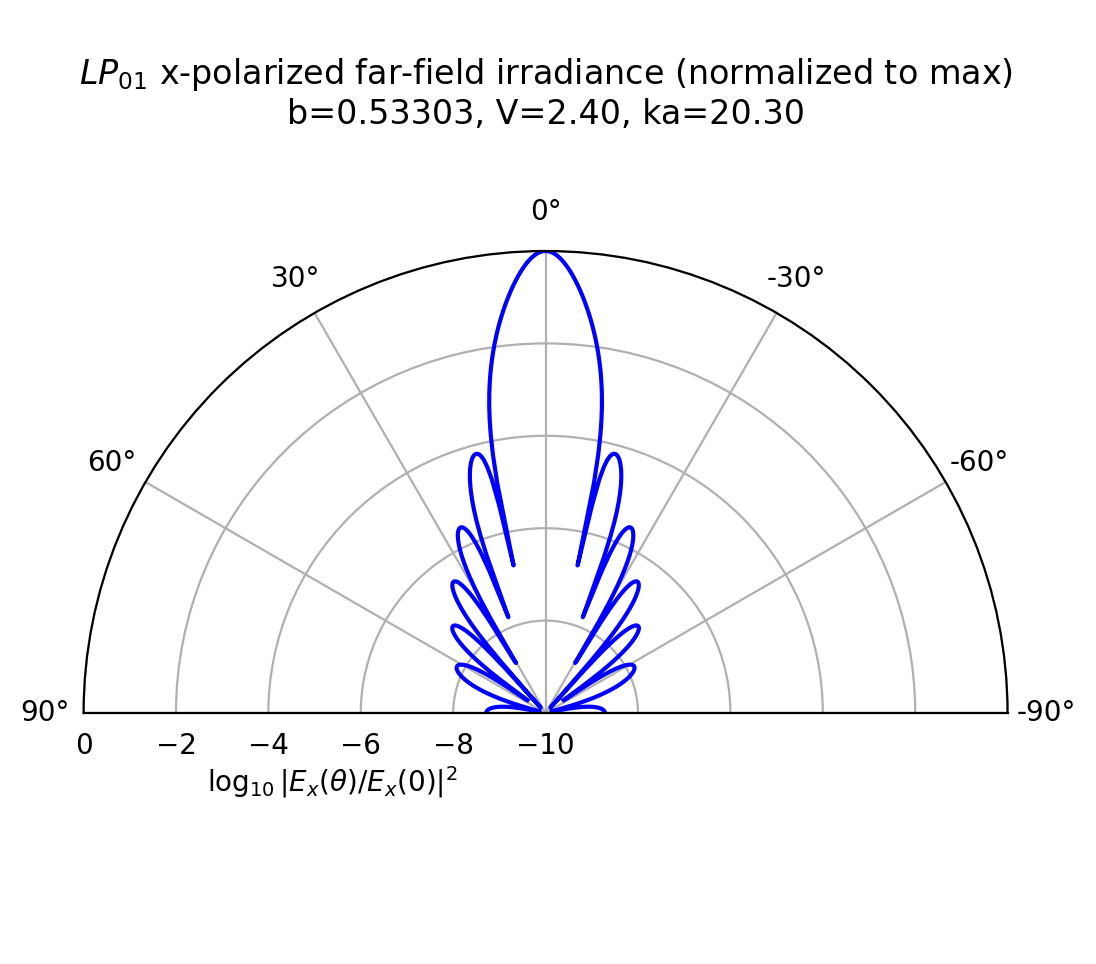

In [3]:
title = '$LP_{01}$ x-polarized far-field irradiance (normalized to max)\n'
title += r'b=%.5f, V=%.2f, ka=%.2f' % (b, V, a)
rlabel = r'$\log_{10}|E_x(\theta)/E_x(0)|^2$'

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(6,6))
ax.plot(theta, np.log10(F), 'b')
ax.set_theta_zero_location("N") 
ax.set_thetalim(np.pi / 2, -np.pi / 2)
ax.set_ylim(-10,0)
ax.grid(True)
ax.set_title(title, va='bottom', pad=-40)
plt.figtext(0.23, 0.23, rlabel, ha='left', va='bottom')
plt.show()

## Emission angle variation with the radius of the fiber core.

We seek the the fundamental mode emission angle for the $\text{LP}_{01}$ cylindrical fiber mode over a range of core radii.

### Calculate the normalized propagation constant vs core radii

Calculate the relative refractive index $\Delta$, numerical aperture NA, and generalized frequency $V$ assuming fixed $n_{\mathrm{core}}$ and $n_{\mathrm{cladding}}$ refractive indices.  

Here we find the $b$ values using the imporoved `LP_mode_value` from version 0.8.0 of `ofiber`.

In [4]:
ell = 0
em = 1
n_core = 1.589
n_cladding = 1.48
lambda0 = 0.550                  # center wavelength over visible spectrum 0.400-0.700 µm
a = np.linspace(2, 15, num=131)  # core radii from 2-15 microns

Delta = ofiber.relative_refractive_index(n_core, n_cladding)
NA = ofiber.numerical_aperture_from_Delta(n_core, Delta)
V = ofiber.V_parameter(a, NA, lambda0)
b_ofiber = ofiber.LP_mode_value(V, ell, em)

### Alternate method 

The routine `ofiber.LP_mode_value` (version 0.7.1 of ofiber and earlier) breaks down for very large $V$ values, so an alternate method, taking advantage of the monotonic increase of $b(V)$, is used.

The routine `ofiber.LP_mode_value` works for the first $V$ value. We use this to find the lower bound for all remaining $b$ values. (Using a lower bound of $b=0$ in the bracketing algorithm may lead to errors.)

In [5]:
ell = 0
em = 1
n_core = 1.589
n_cladding = 1.48
lambda0 = 0.550                  # center wavelength over visible spectrum 0.400-0.700 µm
a = np.linspace(2, 15, num=131)  # core radii from 2-15 microns

Delta = ofiber.relative_refractive_index(n_core, n_cladding)
NA = ofiber.numerical_aperture_from_Delta(n_core, Delta)
V = ofiber.V_parameter(a, NA, lambda0)

b = np.zeros_like(V)
b[0] = ofiber.LP_mode_value(V[0], ell, em)

for i in range(1,len(V)):
    b[i] = (scipy.optimize.root_scalar(f=ofiber.cylinder_step._cyl_mode_eqn, args=(V[i], 0),bracket=(b[i-1],1))).root

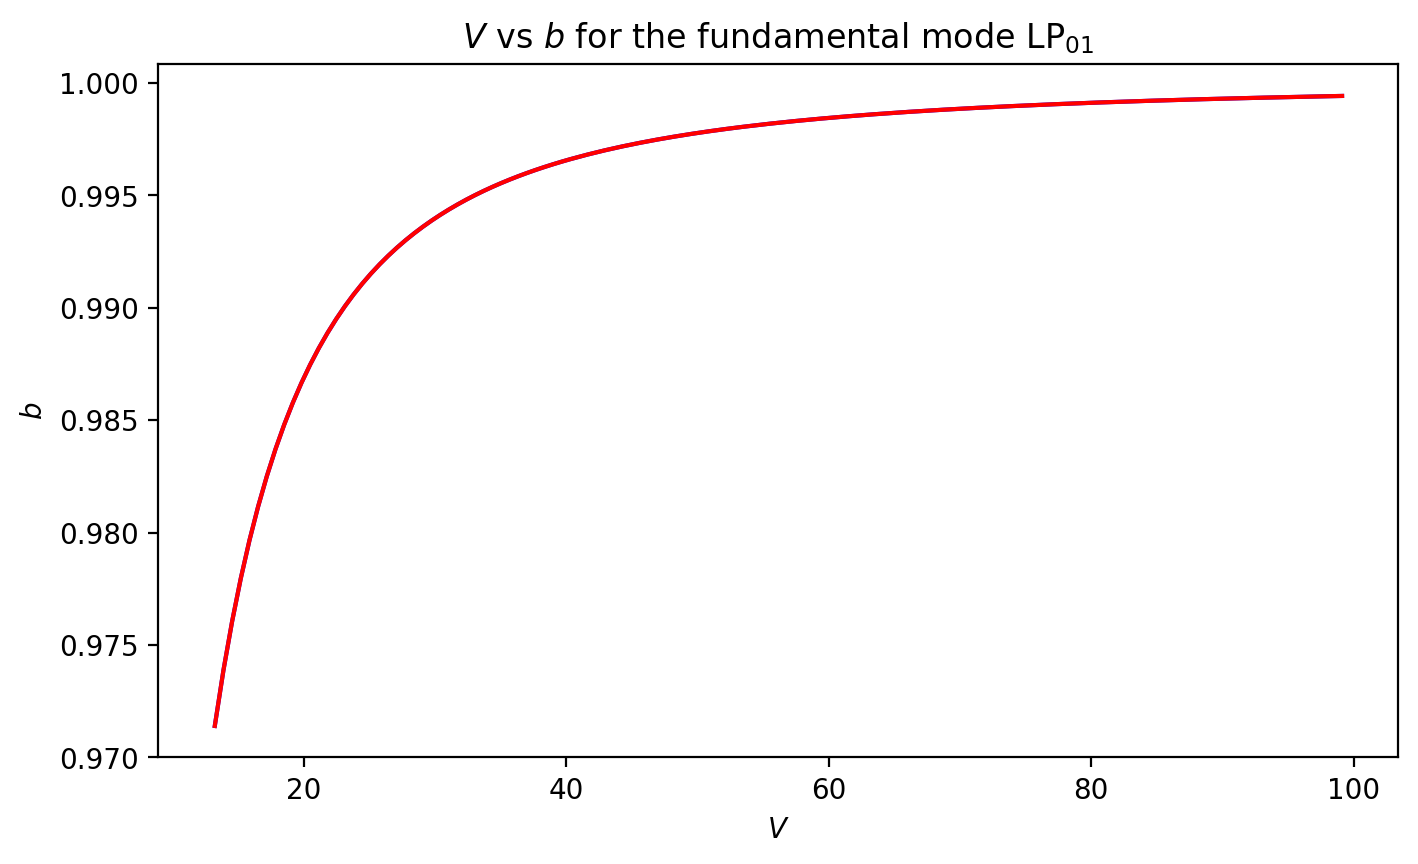

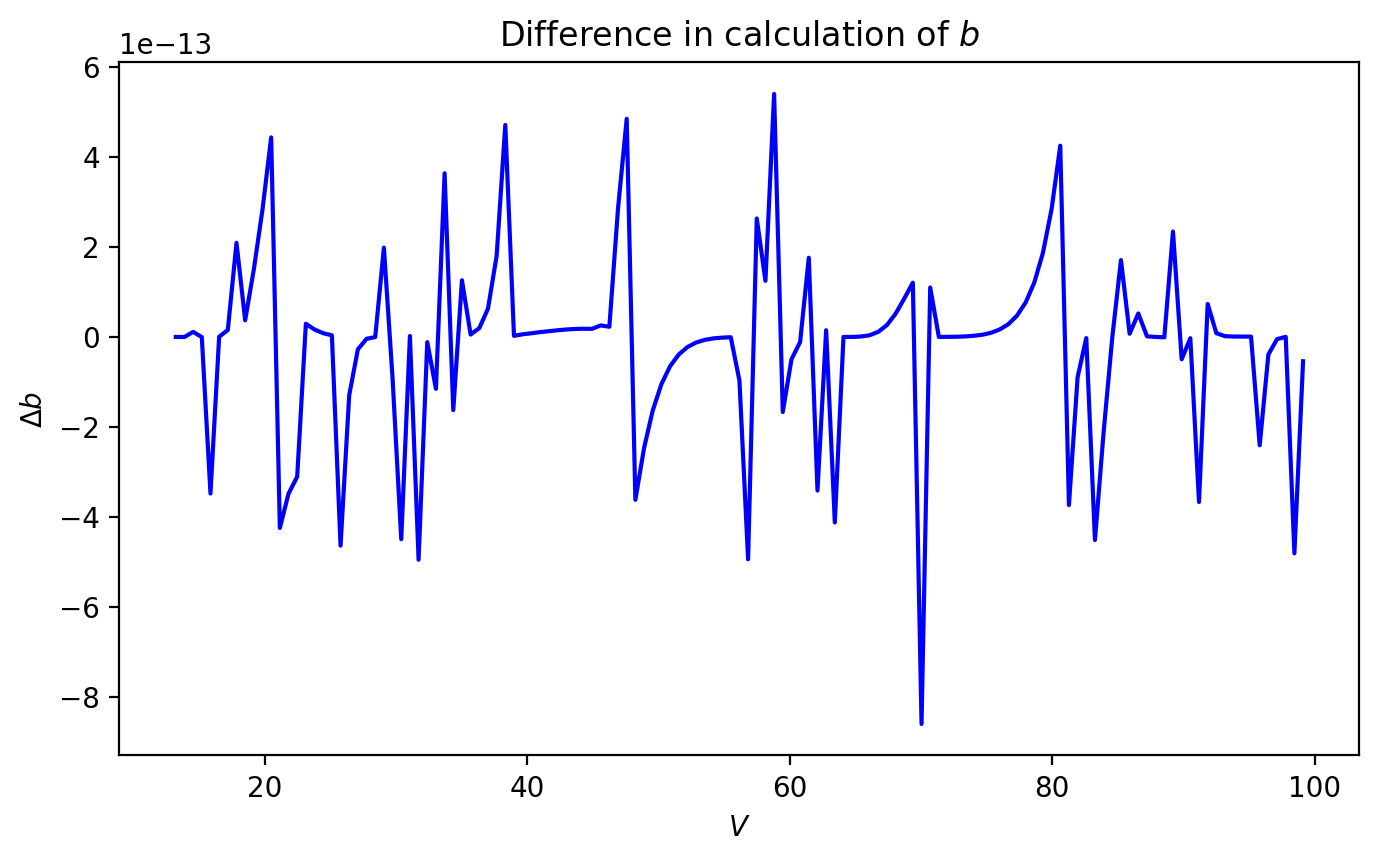

In [6]:
# plot both versions.  they yield equal values
plt.figure(figsize=(8,4.5))
plt.xlabel(r'$V$')
plt.ylabel(r'$b$')
plt.plot(V,b, color='blue')
plt.plot(V,b_ofiber, color='red')
plt.title(r"$V$ vs $b$ for the fundamental mode $\text{LP}_{01}$")
plt.show()

plt.figure(figsize=(8,4.5))
plt.xlabel(r'$V$')
plt.ylabel(r'$\Delta b$')
plt.plot(V,b-b_ofiber, color='blue')
plt.title("Difference in calculation of $b$")
plt.show()

### Calculate the irradiance for each core radius at all polar angles 0-90°

Calculate the irradiance as a function of polar angle for every fiber core radius.  We first create a matrix of size $N_{\theta} \times N_{a}$ and then fill each column with the far-field irradiance at each polar angle.

In [12]:
theta = np.radians(np.linspace(0, 90, 1801))
I_a_theta = np.zeros((len(theta), len(a)))

r = 100
ell = 0
lambda0 = 0.55
for i in range(len(V)):
    I_a_theta[:,i] = ofiber.FF_polar_irradiance_x(r,theta,ell,lambda0,a[i],V[i],b[i]) 

### Extract the polar angle of the minimum of the central irradiance lobe for each $a$ value. 
Find the first minimum $\Theta_{01}$ of $I \propto |E_{\mathrm{FF}x}|^{2}$ when starting the search from $\Theta = 0$ and increasing. (For the fundamental mode, the first minimum is always at a nonzero $\Theta$.)

In [13]:
firstMin = np.zeros_like(a)

for i in range(a.size):
    peaks, _ = scipy.signal.find_peaks(-I_a_theta[:,i])
    firstMin[i] = theta[peaks[0]]

### Plot of emission angle vs fiber radius

Define the fit function for the angle $\theta_{01}$ vs $a$ curve.

In [14]:
def fxinv(radius, b, c):
    return b/radius + c

Fit the $x^{-1}$ function `fxinv` to the firstMinDeg as a function of the fiber radius.  First convert $\theta_{01}$ from radians to degrees, to ease visualization.

In [15]:
firstMinDeg = np.degrees(firstMin)  # convert the first min angle peak to degrees
popt, pcov = scipy.optimize.curve_fit(fxinv, a, firstMinDeg)
fit = fxinv(a,popt[0],popt[1])

Plot the emission angle calculations and the fit function.  We see that in this regime, $\theta_{01}(a) = \frac{b}{a} + c$. The inverse of this fit is $\frac{b}{\theta - c} = a$.

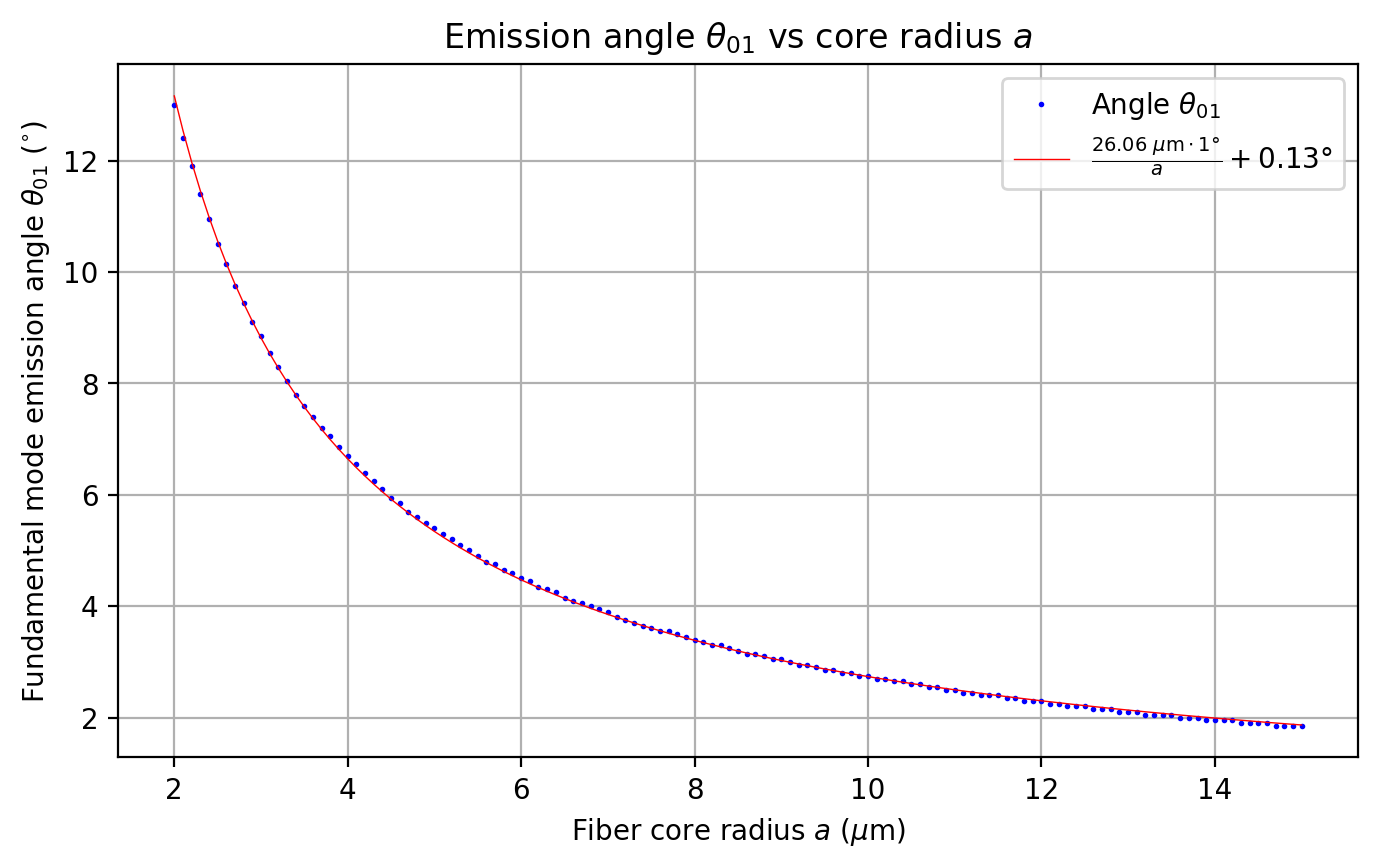

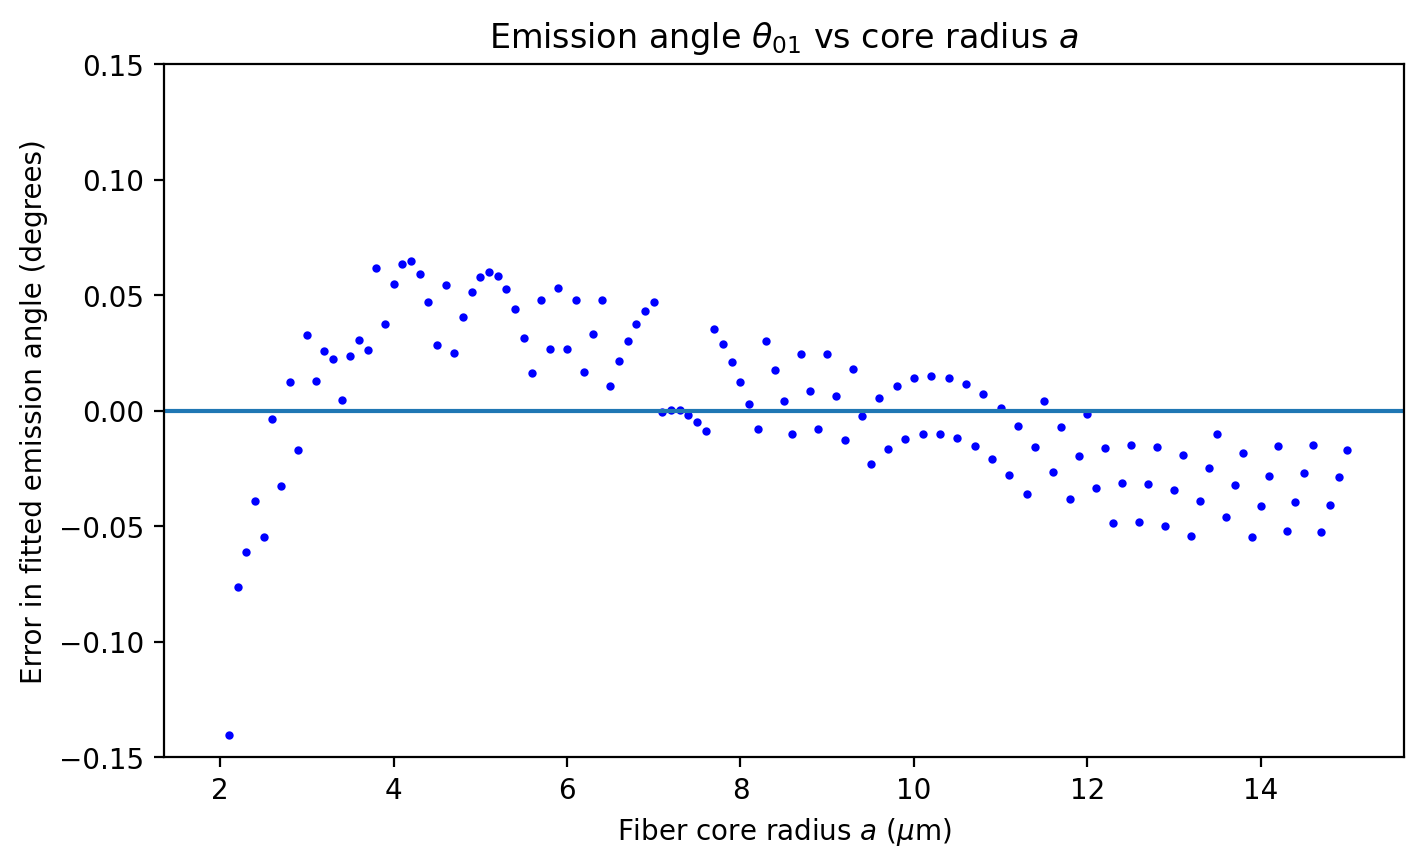

In [16]:
plt.figure(figsize=(8,4.5))
plt.xlabel(r'Fiber core radius $a$ ($\mu$m)')
plt.ylabel(r'Fundamental mode emission angle $\theta_{01}$ ($^{\circ}$)')
plt.title(r'Emission angle $\theta_{01}$ vs core radius $a$')
plt.plot(a, firstMinDeg, 'ob', label=r'Angle $\theta_{01}$', markersize=1)
s = r'$\frac{%5.2f \ \mu \text{m}\cdot 1°}{a} + %5.2f°$' % tuple(popt)
plt.plot(a, fit,label=s, lw=0.5, color='red')
plt.grid()
plt.legend()
plt.show()

plt.figure(figsize=(8,4.5))
plt.xlabel(r'Fiber core radius $a$ ($\mu$m)')
plt.ylabel('Error in fitted emission angle (degrees)')
plt.title(r'Emission angle $\theta_{01}$ vs core radius $a$')
plt.plot(a, firstMinDeg-fit, 'ob', lw=0.5, markersize=2)
plt.axhline(0)
plt.ylim(-0.15,0.15)
plt.show()